In [1]:
import numpy as np
import cv2
from utils import imshow, get_clicked_points

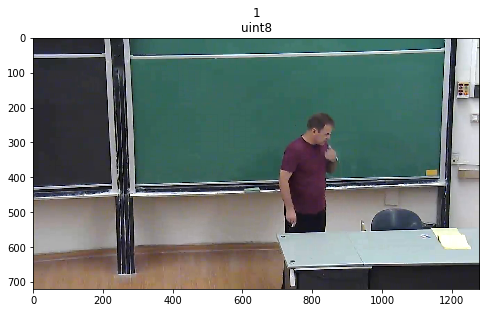

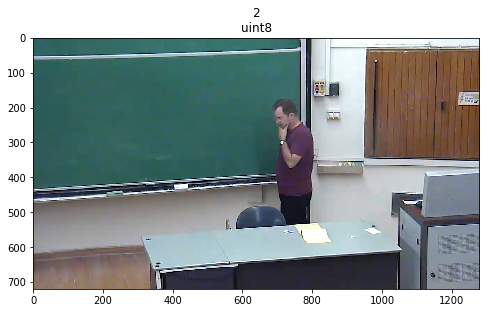

In [2]:
im1 = cv2.imread('../1.png')
im2 = cv2.imread('../2.png')
imshow('1', im1)
imshow('2', im2)

%matplotlib tk
# points = get_clicked_points(im1)
get_clicked_points(im2)
%matplotlib inline

In [3]:
points1 = [(1177.3194386258904, 41.87955592794299), (698.4757017176373, 562.1979472140763), (1218.7940930037705, 132.3697109342271), (1253.9847088395477, 603.6726015919564)]
points2 = [(763.8297025555091, 41.87955592794299), (311.3789275240889, 570.9956011730205), (806.5611646418099, 124.82886468370339), (853.0630498533726, 584.8204859656473)]
points1 = np.array(points1)
points2 = np.array(points2)

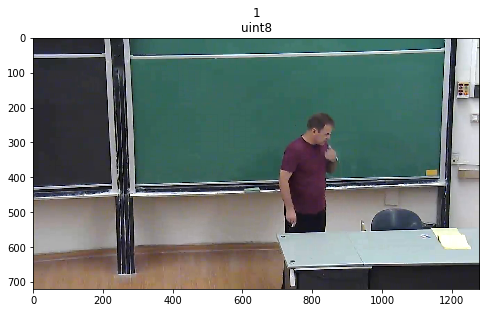

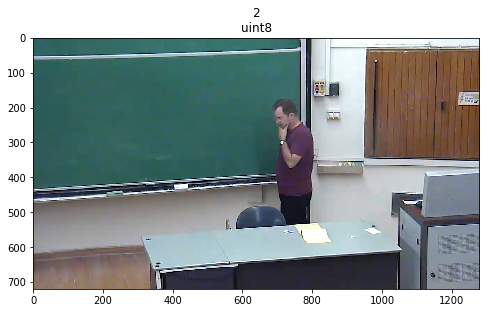

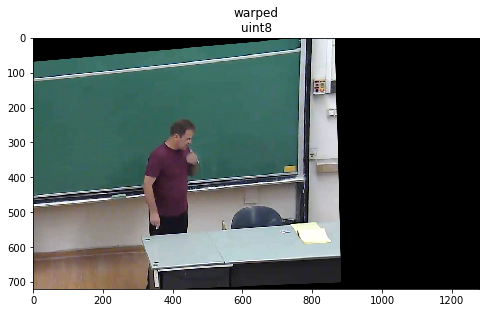

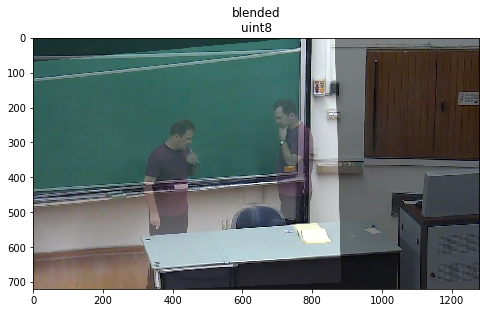

In [6]:
h, status = cv2.findHomography(points1, points2)
im_out = cv2.warpPerspective(im1, h, (im2.shape[1],im2.shape[0]))
imshow('1', im1)
imshow('2', im2)
imshow('warped', im_out)
imshow('blended', cv2.addWeighted(im_out,0.5,im2,0.5,0))

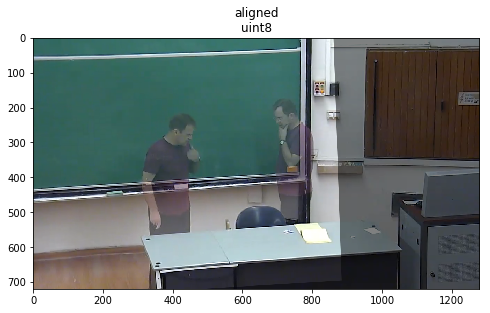

In [5]:

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
 
def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 
aligned = alignImages(im1, im2)[0]
imshow('aligned', cv2.addWeighted(im2,.5,aligned,.5,0))

In [6]:
cap = cv2.VideoCapture('../lecture.mp4')
for _ in range(120):
    ret = cap.grab()

_, first = cap.read()

while 1:
    _, frame = cap.read()
    if not _:
        break
    
    aligned, h = alignImages(frame, first)
    cv2.imshow('video', cv2.addWeighted(aligned,0.5,first,0.5,0))
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
        
cv2.destroyAllWindows()
cap.release()